<a href="https://colab.research.google.com/github/vshalisko/ARC_analysis_scripts/blob/master/Copia_de_Landsat_ANN_test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Uso de ANN para clasificacion de Landsat

In [12]:
!pip install pyrsgis
!pip install geemap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.6 MB/s eta 0:00:00


Preparar el entorno

In [13]:
import ee
import geemap
import random
import math, glob, time
import numpy as np
from pyrsgis import raster, convert
import matplotlib.pyplot as plt
from google.colab import drive

random.seed(2)

Conección con GEE

In [14]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-viacheslavs')

Coneccion con Google Drive para almacenar archivos

In [15]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Lectura de capas de datos

In [16]:
punto_interes = ee.Geometry.Point([-103.76, 19.75])
fecha_inicio = '2015-02-01'
fecha_final = '2015-05-30'
fecha_inicio_2020 = '2020-02-01'
fecha_final_2020 = '2020-05-30'

print(punto_interes.getInfo())

# filtrado de datos Landsat potencialemtne adecuados
L8_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(punto_interes).filterDate(fecha_inicio, fecha_final).filter(ee.Filter.lessThan('CLOUD_COVER', 1))
print('Capas de datos filtrados:', L8_collection.size().getInfo())

# Cargar imagen de la colección (Landsat 8).
L8_image = L8_collection.first()

L8_collection_2020 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(punto_interes).filterDate(fecha_inicio_2020, fecha_final_2020).filter(ee.Filter.lessThan('CLOUD_COVER', 1))
print('Capas de datos filtrados:', L8_collection_2020.size().getInfo())
L8_image_2020 = L8_collection_2020.first()

# Load builtup 2015 (res 100 m)
ghs_built_image = ee.Image('JRC/GHSL/P2023A/GHS_BUILT_S/2015')
built_2015_lr = ghs_built_image.select('built_surface')

# Load builtup 2015 (res 10 m)
built_2015_hr = ee.Image('DLR/WSF/WSF2015/v1')

# blackBackground = ee.Image(0);


{'type': 'Point', 'coordinates': [-103.76, 19.75]}
Capas de datos filtrados: 2
Capas de datos filtrados: 4


Visualizar capas de datos

In [19]:
Map = geemap.Map()
# Center the map and display the image.
Map.centerObject(punto_interes, 8)

# Parametros de visualizacion para Landsat 8
vizParams_L8 = {
  'bands': ['SR_B5', 'SR_B4', 'SR_B3'],
   'min': 5000,
   'max': 15000
  #'gamma': [0.95, 1.1, 1]
}
# Parametros de visualizacion para Builtup LR
vizBuiltup_LR = {
   'min': 0,
   'max': 1,
  'palette': ['white','black']
}
# Parametros de visualizacion para Builtup HR
vizBuiltup_HR = {
  min: 0,
  max: 255,
  'palette': ['white','black']
}

# Agregar capas
Map.addLayer(L8_image, vizParams_L8, 'Composición de falso color 2015', True, 0.5)
Map.addLayer(L8_image_2020, vizParams_L8, 'Composición de falso color 2020', True, 0.5)
Map.addLayer(built_2015_lr, vizBuiltup_LR, 'Builtup 2015 100m', True, 0.5)
Map.addLayer(built_2015_hr, vizBuiltup_HR, 'Builtup 2015 10m', True, 0.5)

# presentar mapa
print(Map)



Map(center=[19.75, -103.76], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(children=(ToggleButton(value=False, icon='globe', layout=Layout(height='28px', padding='0px 0px 0px 4px', width='28px'), tooltip='Search location/data'),), _dom_classes=('geemap-colab',))), ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text', 'zoom_out_title']), FullScreenControl(options=['position']), MapDrawControl(marker={'shapeOptions': {'color': '#3388ff'}}, options=['position'], polygon={'shapeOptions': {}}, polyline={'shapeOptions': {}}, rectangle={'shapeOptions': {'color': '#3388ff'}}), ScaleControl(options=['imperial', 'max_width', 'metric', 'position', 'update_when_idle'], position='bottomleft'), MeasureControl(active_color='orange', options=['active_color', 'capture_z_index', 'completed_color', 'popup_options', 'position', 'primary_area_unit', 'primary_length_unit', 'secondary_area_unit', 'secondary_length_unit'], popup_options={'cla

In [20]:
Map

Map(center=[19.75, -103.76], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

Conversión de datos en numpy array para el analisis

In [21]:
image_meta = L8_image.getInfo()
imagename = image_meta.get('properties',{}).get('LANDSAT_PRODUCT_ID')
#imagename = image_meta.get('properties',{})
print(imagename)

projection = L8_image.projection().getInfo();
print(projection)
print(projection.get('crs'))

## Reproject label layer
built_2015_hr_reprojected = built_2015_hr.reproject(projection.get('crs'), projection.get('transform'))
#print(built_2015_hr_reprojected.getInfo())

# convert all to UTM in order to get good rectangle
#limites_geo = [-103.65,-103.05, 20.43, 20.95]
limites_utm = [640000, 703000, 2258000, 2318000]
pixel = 30
max_tile = 250000
utm13 = ee.Projection('EPSG:32613')


def segmentation(limits, pixel_size, max_tile_size, proj):
  alto = math.ceil((limits[3] - limits[2]) / pixel_size)
  print('Alto del segmento (pixeles)', alto)
  ancho = math.ceil(max_tile_size / alto)
  print('Ancho del segmento (pixeles)', ancho)
  incremento = ancho * pixel_size
  print('Ancho del segmento (unidades de proyeccion)', incremento)
  seq = list(np.arange(limits[0], limits[1], incremento))
  print('Secuencia de marcas de longitud')
  print(seq)
  segments = []
  for i in range(len(seq)-1):
    #print(seq[i], seq[i+1])
    segment = ee.Geometry.Rectangle([int(seq[i]), limites_utm[2], int(seq[i+1]), limites_utm[3]], proj, True, False)
    #print(segment)
    segments.append(segment)
  return segments

segment_list = segmentation(limites_utm, pixel, max_tile, utm13)

Map1 = geemap.Map()
bbox = ee.Geometry.Rectangle([limites_utm[0], limites_utm[2], limites_utm[1], limites_utm[3]], utm13, True, False)
Map1.centerObject(punto_interes, 8)
Map1.addLayer(bbox, {}, 'Area de estudio')
Map1

LC08_L2SP_029046_20150208_20200909_02_T1
{'type': 'Projection', 'crs': 'EPSG:32613', 'transform': [30, 0, 551685, 0, -30, 2352915]}
EPSG:32613
Alto del segmento (pixeles) 2000
Ancho del segmento (pixeles) 125
Ancho del segmento (unidades de proyeccion) 3750
Secuencia de marcas de longitud
[640000, 643750, 647500, 651250, 655000, 658750, 662500, 666250, 670000, 673750, 677500, 681250, 685000, 688750, 692500, 696250, 700000]


Map(center=[19.75, -103.76], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [22]:
bands_L8 = ['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']
bands_B = ['settlement']

def tile_to_numpy(image, rectangle, bands):
  ## extraccion de bandas en un region rectangular
  image_tile = image.sampleRectangle(region=rectangle,defaultValue=0)
  first_band = image_tile.get(bands[0])
  band_array_np = np.array(first_band.getInfo())
  band_array_np = np.expand_dims(band_array_np, 2)
  for b in bands[1:]:
    b_arr = image_tile.get(b)
    b_arr_np = np.array(b_arr.getInfo())
    b_arr_np = np.expand_dims(b_arr_np, 2)
    #print(b_arr_np.shape)
    #print(band_array_np.shape)
    band_array_np = np.concatenate((band_array_np, b_arr_np), 2)
  return band_array_np


In [23]:
# definición de un region pequeño para el analisis (GEO)
aoi0 = ee.Geometry.Polygon(
        [[[-103.42046006557397, 20.721686475573005],
          [-103.42046006557397, 20.694710560279958],
          [-103.39846006557397, 20.694710560279958],
          [-103.39846006557397, 20.721686475573005]]], None, False);
aoi1 = ee.Geometry.Polygon(
        [[[-103.39846006557397, 20.721686475573005],
          [-103.39846006557397, 20.694710560279958],
          [-103.36309782192163, 20.694710560279958],
          [-103.36309782192163, 20.721686475573005]]], None, False);
aoi2 = ee.Geometry.Polygon(
        [[[-103.36309782192163, 20.721686475573005],
          [-103.36309782192163, 20.694710560279958],
          [-103.32773557826929, 20.694710560279958],
          [-103.32773557826929, 20.721686475573005]]], None, False);

Cero feature array (102, 79, 6)
First feature array (102, 124, 6)
Second feature array (102, 125, 6)
Small test feature array (102, 328, 6)


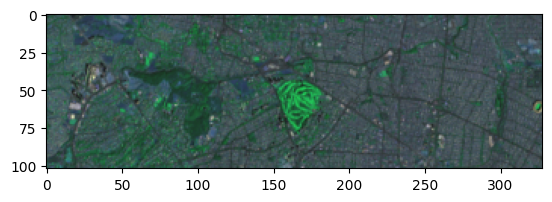

In [24]:
array0 = tile_to_numpy(L8_image, aoi0, bands_L8)
print("Cero feature array", array0.shape)
array1 = tile_to_numpy(L8_image, aoi1, bands_L8)
print("First feature array", array1.shape)
array2 = tile_to_numpy(L8_image, aoi2, bands_L8)
print("Second feature array", array2.shape)

array_small_feature = np.concatenate((array0, array1, array2), 1)
print("Small test feature array", array_small_feature.shape)

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_test = (255*((array_small_feature - 5000)/30000)).astype('uint8')
plt.imshow(rgb_img_test[:,:,2:5])
plt.show()

Cero Label array (102, 79, 1)
Firsy label array (102, 124, 1)
Second label array (102, 125, 1)
Small test label array (102, 328, 1)


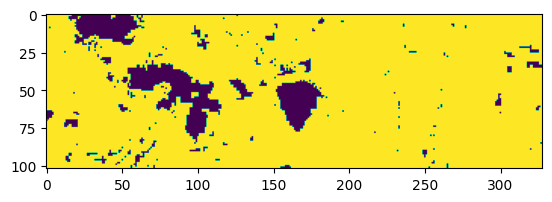

In [25]:
arrayL0 = tile_to_numpy(built_2015_hr_reprojected, aoi0, bands_B)
print("Cero Label array", arrayL0.shape)
arrayL1= tile_to_numpy(built_2015_hr_reprojected, aoi1, bands_B)
print("Firsy label array", arrayL1.shape)
arrayL2 = tile_to_numpy(built_2015_hr_reprojected, aoi2, bands_B)
print("Second label array", arrayL2.shape)

array_small_labels = np.concatenate((arrayL0, arrayL1, arrayL2), 1)
print("Small test label array", array_small_labels.shape)

# Scale the data to [0, 255] to show as an RGB image.
B_img_test = (array_small_labels).astype('uint8')
plt.imshow(B_img_test[:,:,0])
plt.show()

In [26]:
# Save the arrays as .npy files
np.save('/content/drive/MyDrive/Colab Data/array_small_feature.npy', array_small_feature)
np.save('/content/drive/MyDrive/Colab Data/array_small_labels.npy', array_small_labels)

Preparar datos de entrenamiento en zona de estudio

New feature array (2001, 126, 6)
Feature segment (2001, 126, 6)
Feature segment (2001, 126, 6)
Feature segment (2001, 126, 6)
Feature segment (2001, 126, 6)
Feature segment (2001, 126, 6)
Feature segment (2001, 126, 6)
Feature segment (2001, 126, 6)
Feature segment (2001, 126, 6)
Feature segment (2001, 126, 6)
Feature segment (2001, 126, 6)
Feature segment (2001, 126, 6)
Feature segment (2001, 126, 6)
Feature segment (2001, 126, 6)
Feature segment (2001, 126, 6)
Feature segment (2001, 126, 6)
Full new feature array (2001, 2016, 6)


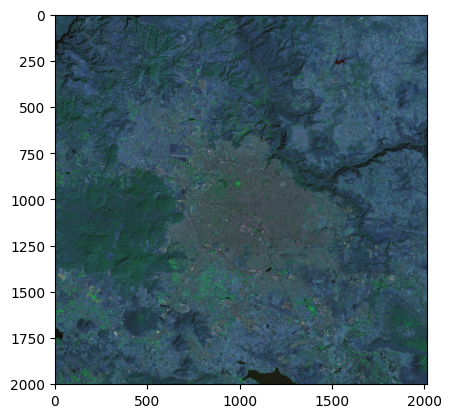

In [27]:
array_feature = tile_to_numpy(L8_image, segment_list[0], bands_L8)
print("New feature array", array_feature.shape)
for segment in segment_list[1:]:
  feature_segment = tile_to_numpy(L8_image, segment, bands_L8)
  print("Feature segment", feature_segment.shape)
  array_feature = np.concatenate((array_feature, feature_segment), 1)
print("Full new feature array", array_feature.shape)

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_new = (255*((array_feature - 5000)/30000)).astype('uint8')
plt.imshow(rgb_img_new[:,:,2:5])
plt.show()

New label array (2001, 126, 1)
Label segment (2001, 126, 1)
Label segment (2001, 126, 1)
Label segment (2001, 126, 1)
Label segment (2001, 126, 1)
Label segment (2001, 126, 1)
Label segment (2001, 126, 1)
Label segment (2001, 126, 1)
Label segment (2001, 126, 1)
Label segment (2001, 126, 1)
Label segment (2001, 126, 1)
Label segment (2001, 126, 1)
Label segment (2001, 126, 1)
Label segment (2001, 126, 1)
Label segment (2001, 126, 1)
Label segment (2001, 126, 1)
Full new label array (2001, 2016, 1)


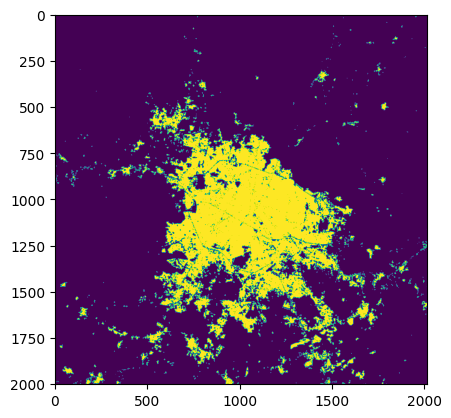

In [28]:
array_target = tile_to_numpy(built_2015_hr_reprojected, segment_list[0], bands_B)
print("New label array", array_target.shape)
for segment in segment_list[1:]:
  target_segment = tile_to_numpy(built_2015_hr_reprojected, segment, bands_B)
  print("Label segment", target_segment.shape)
  array_target = np.concatenate((array_target, target_segment), 1)
print("Full new label array", array_target.shape)

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_new = (array_target).astype('uint8')
plt.imshow(rgb_img_new[:,:,0])
plt.show()

In [29]:
# Save the arrays as .npy files
np.save('/content/drive/MyDrive/Colab Data/array_full_feature.npy', array_feature)
np.save('/content/drive/MyDrive/Colab Data/array_full_target.npy', array_target)

In [30]:
#array_full_t = np.transpose(array_small_feature, (2, 0, 1))
#array_labels_t = np.transpose(array_small_labels, (2, 0, 1))

array_full_t = np.transpose(array_feature, (2, 0, 1))
array_labels_t = np.transpose(array_target, (2, 0, 1))


print(array_full_t.shape)
print(array_labels_t.shape)
x_features = convert.array_to_table(array_full_t)
y_labels = convert.array_to_table(array_labels_t)
#featuresHyderabad = changeDimension(featuresHyderabad)
nBands = x_features.shape[1]
#labelBangalore = (labelBangalore == 1).astype(int)

print(x_features.shape)
print(x_features)
print(y_labels.shape)
print(y_labels)

unique_values, occurrence_count = np.unique(y_labels, return_counts=True)
print(unique_values)
print(occurrence_count)

(6, 2001, 2016)
(1, 2001, 2016)
(4034016, 6)
[[ 9622 10481 11343 15059 18775 15397]
 [ 9528 10279 10997 15807 18234 14941]
 [10054 11108 12080 16201 20200 17099]
 ...
 [ 8854  9247  9665 11904 15008 13274]
 [ 8882  9350  9841 12095 15437 13560]
 [ 9047  9605 10178 12611 16129 14025]]
(4034016, 1)
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
[  0 255]
[3356712  677304]


In [31]:
from sklearn.model_selection import train_test_split

# Normalise the data
y_labels = y_labels / 255
x_features = x_features / 32768

xTrain, xTest, yTrain, yTest = train_test_split(x_features, y_labels, test_size=0.4, random_state=42)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

print(xTrain)
print(yTrain)

# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))

print(xTrain.shape, xTest.shape)

(2420409, 6)
(2420409, 1)
(1613607, 6)
(1613607, 1)
[[0.26696777 0.27835083 0.29440308 0.40002441 0.43673706 0.35592651]
 [0.26068115 0.28561401 0.28808594 0.49194336 0.4440918  0.36968994]
 [0.27288818 0.28677368 0.3024292  0.39828491 0.47631836 0.41003418]
 ...
 [0.34078979 0.38430786 0.40267944 0.46679688 0.49215698 0.4727478 ]
 [0.2460022  0.25604248 0.25473022 0.37023926 0.36013794 0.29501343]
 [0.26797485 0.29467773 0.29998779 0.49807739 0.43899536 0.37011719]]
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [0.]
 [0.]]
(2420409, 1, 6) (1613607, 1, 6)


Train neural network

In [32]:
from tensorflow import keras

# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(14, activation='relu'),
    keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Run the model
model.fit(xTrain, yTrain, epochs=5)

Epoch 1/5
75638/75638 [==============================] - 133s 2ms/step - loss: 0.1781 - accuracy: 0.9355
Epoch 2/5
75638/75638 [==============================] - 135s 2ms/step - loss: 0.1521 - accuracy: 0.9442
Epoch 3/5
75638/75638 [==============================] - 129s 2ms/step - loss: 0.1503 - accuracy: 0.9446
Epoch 4/5
75638/75638 [==============================] - 133s 2ms/step - loss: 0.1496 - accuracy: 0.9447
Epoch 5/5
75638/75638 [==============================] - 130s 2ms/step - loss: 0.1493 - accuracy: 0.9448


In [33]:
model.save('/content/drive/MyDrive/Colab Data/model_full_data_test.tensorflow')

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Predict for test data
yTestPredicted = model.predict(xTest)
yTestPredicted = yTestPredicted[:,1]

# Calculate and display the error metrics
yTestPredicted = (yTestPredicted>0.5).astype(int)
cMatrix = confusion_matrix(yTest, yTestPredicted)
accuracy = accuracy_score(yTest, yTestPredicted)
pScore = precision_score(yTest, yTestPredicted)
rScore = recall_score(yTest, yTestPredicted)
f1Score = f1_score(yTest, yTestPredicted)

print("Confusion matrix:\n", cMatrix)
print("\naccuracy: %.3f," % accuracy)
print("\nprecision: %.3f, recall: %.3f, f1: %.3f" % (pScore, rScore, f1Score))

46998/50426 [==========================>...] - ETA: 4s

In [ ]:
x_features_n = x_features
x_features_n = x_features_n.reshape((x_features_n.shape[0], 1, x_features_n.shape[1]))

predicted = model.predict(x_features_n)
print(predicted)





118800/118800 [==============================] - 187s 2ms/step
[[0.99730045 0.00269964]
 [0.99786866 0.00213137]
 [0.99672765 0.00327231]
 ...
 [0.9983912  0.00160872]
 [0.9983993  0.00160063]
 [0.9987595  0.0012405 ]]


[[0.00269964 0.00213137 0.00327231 ... 0.00572213 0.0063163  0.0042326 ]
 [0.00263793 0.001415   0.00166925 ... 0.00136544 0.00122831 0.00114613]
 [0.00717571 0.00494043 0.00669244 ... 0.00082678 0.00092152 0.00073393]
 ...
 [0.00443353 0.00097902 0.00276694 ... 0.00224799 0.00335831 0.00800864]
 [0.08125945 0.00273142 0.00555675 ... 0.00234028 0.00592808 0.00413075]
 [0.0505318  0.00808099 0.01306629 ... 0.00160872 0.00160063 0.0012405 ]]


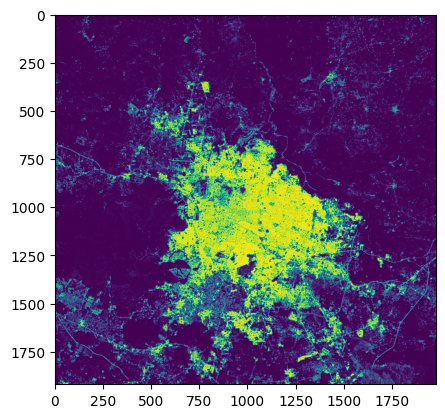

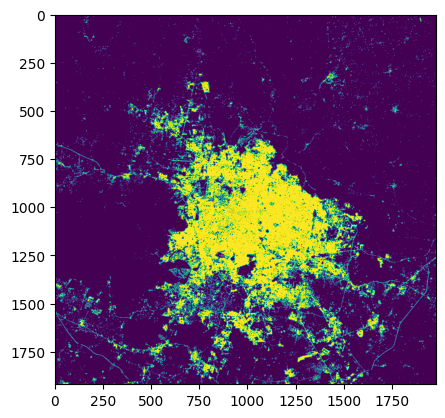

In [ ]:
#predicted = predicted * 255

prediction = np.reshape(predicted[:,1], (array_target.shape[0], array_target.shape[1]))
print(prediction)
B_img_pred = (prediction).astype('float')
plt.imshow(B_img_pred[:,:])
plt.show()
B1_img_pred = (prediction>0.5).astype('uint8')
plt.imshow(B1_img_pred[:,:])
plt.show()